In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from requests import get
import requests
from bs4 import BeautifulSoup
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import plotly.express as px


CEMBI = 'https://www.ishares.com/us/products/239525/ishares-emerging-markets-corporate-bond-etf/1467271812596.ajax?fileType=csv&fileName=CEMB_holdings&dataType=fund'
EMBI = 'https://www.ishares.com/us/products/239572/ishares-jp-morgan-usd-emerging-markets-bond-etf/1467271812596.ajax?fileType=csv&fileName=EMB_holdings&dataType=fund'
GBI = 'https://www.ishares.com/us/products/239528/ishares-emerging-markets-local-currency-bond-etf/1467271812596.ajax?fileType=csv&fileName=LEMB_holdings&dataType=fund'

indexchoice = EMBI
if indexchoice in [EMBI,CEMBI]:
    categories = ["Location","Sector","Name"]
else:
    categories = ["Location","Sector"]
chartnames= {EMBI:"EMBI",CEMBI:"CEMBI",GBI:"GBI"}

df = pd.read_csv(indexchoice, header=9)
datalist = ["YTM (%)","Maturity","Mod. Duration","Yield to Worst (%)","Location"]
df1 = df[datalist]
df1 = df1.set_index("Location")

def get_year(x):
    x = str(x)
    try: 
        return(int(x[-4:]))
    except:
        pass
    
df1["year"] = df1["Maturity"].apply(get_year)
df1 = df1[df1["year"] < 2035]
df1 = df1[df1["year"] > 2027]
df1["YTW"] = pd.to_numeric(df1["Yield to Worst (%)"],errors="coerce")

[18 21 13 16 14 9 7 15 19 23 11 12 17 10 'CCC' 6 22]


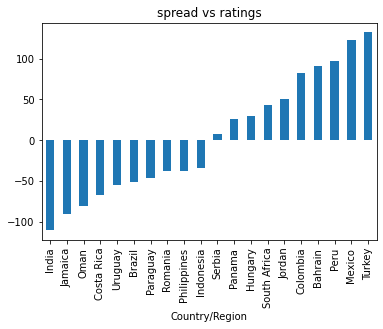

In [21]:
#get ratings from wikipedia
url = "https://en.wikipedia.org/wiki/List_of_countries_by_credit_rating"
results = requests.get(url)
soup = BeautifulSoup(results.text, "html.parser")
table=soup.find_all('table',{'class':"wikitable"})
ratings_list = soup.find_all("td", style="display:none")

df_lists = []
for x in table:
    df_demos=pd.read_html(str(x),flavor='bs4')
    df_lists.append(df_demos)
    
ratings_dict = {"AAA+":1,
    "AAA":2,
    "AAA-":3,
    "AA+":4,
    "AA":5,
    "AA-":6,
    "A+":7,
    "A":8,
    "A-":9,
    "BBB+":10,
    "BBB":11,
    "BBB-":12,
    "BB+":13,
    "BB":14,
    "BB-":15,
    "B+":16,
    "B":17,
    "B-":18,
    "CCC+":19,
    "CCC-":21,
    "CC":22,
    "C":23,            
    "SD":23
              }

ratings_dict_small = {"AAA+":1,
    "AAA":1,
    "AAA-":1,
    "AA+":2,
    "AA":2,
    "AA-":2,
    "A+":3,
    "A":3,
    "A-":3,
    "BBB+":4,
    "BBB":4,
    "BBB-":4,
    "BB+":5,
    "BB":5,
    "BB-":5,
    "B+":6,
    "B":6,
    "B-":6,
    "CCC+":7,               
    "SD":7
              }

sp_ratings = df_lists[1][0]
sp_ratings["Rating numbers"] = sp_ratings["Rating"].replace(ratings_dict)
sp_ratings["Rating bucket"] = sp_ratings["Rating"].replace(ratings_dict_small)
sp_ratings = sp_ratings.set_index("Country/Region")

#merge two data sources
df_mean = df1.groupby("Location").mean() #get mean of all of the country's bonds
new_df = sp_ratings.join(df_mean)
new_df = new_df[new_df["YTW"].notnull()]
new_df.to_csv("EMBI_table.csv")

df_scat = new_df.reset_index()
df_scat["Outlook"].fillna("Stable",inplace=True)
print(df_scat["Rating numbers"].unique())
df_scat["Rating numbers"] = df_scat["Rating numbers"].apply(pd.to_numeric, errors="coerce")
df_scat = df_scat[df_scat["Rating numbers"] < 17]

color_sequence = ['#2471A3', '#ABB2B9', '#C0392B']
outlook_colors = {outlook: color for outlook, color in zip(df_scat['Outlook'].unique(), color_sequence)}
fig = px.scatter(df_scat, x="Rating numbers", y="YTW", text="Country/Region",
                 color="Outlook", color_discrete_map=outlook_colors)
fig.update_layout(plot_bgcolor='#F8F9F9') 
fig.update_traces(marker=dict(size=15))
fig.update_layout(xaxis=dict(
    tickmode="array",
    tickvals=np.arange(6,21,2),
    ticktext = ["AA-","A","BBB+","BBB-","BB","B+","B-","CCC-","SD"]))
fig.show()

mean_ytw = dict(new_df.groupby("Rating numbers").mean()["YTW"])
new_df["mean_ytw"] = new_df["Rating numbers"].replace(mean_ytw)
new_df["spread to mean"] =(new_df["YTW"] - new_df["mean_ytw"]) * 100
new_df["Rating numbers"] = new_df["Rating numbers"].apply(pd.to_numeric, errors="coerce")
new_df_mod = new_df[new_df["Rating numbers"] < 18]
n_countries = 10
new_table = new_df_mod["spread to mean"].sort_values().head(n_countries)
new_table = new_table.append(new_df_mod["spread to mean"].sort_values().tail(n_countries))
new_table.plot(kind="bar",title="spread vs ratings")
new_table.to_csv("ytw_vs_peers.csv")

In [3]:

dfc = df #[dfc.Sector == 'Financial Institutions']
dfcn = df
weights = dfcn[dfcn.Sector == 'Financial Institutions'].groupby("Location").sum()["Weight (%)"].sort_index()
#print(weights)
#dfcm = dfcn.groupby('Location').mean()
new_dfc = dfcn.join(sp_ratings)
#weights = (weights / weights.sum() * 100).sort_values()
new_dfc["Weight Sum"] = weights
new_dfc.sort_values("Yield to Worst (%)")
new_dfc.to_csv("fins_ytw.csv")
weights.sort_values()

Series([], Name: Weight (%), dtype: float64)

In [4]:
%matplotlib inline
new_dfc = new_dfc[new_dfc["Weight (%)"] != 0].head(1000)
new_dfc
temp_bool = new_dfc.isnull().sum() > 100
new_dfc = new_dfc.loc[:, ~temp_bool]
temp_bool = new_dfc.isnull().sum(axis=1) > 20
new_dfc = new_dfc.loc[ ~temp_bool,]
new_dfc["YTM (%)"] = pd.to_numeric(new_dfc["YTM (%)"],errors="coerce").round(2)

def create_treemap(df):
    df_des = df["YTM (%)"].fillna(0).describe()
    scale_max = df_des["mean"] + df_des["std"] * 1
    scale_min = df_des["mean"] - df_des["std"] * 1   
    fig = px.treemap(df, 
                     path=categories,
                     values="Weight (%)",
                     color= "YTM (%)",
                     color_continuous_scale='rdylgn_r',
                     range_color = [scale_min,scale_max]
                    )
    zmin = -20
    fig.update_layout(title=f'{chartnames[indexchoice]}')
    plt.savefig(f'{indexchoice[-28:-20]}.png')
    fig.show()
    
create_treemap(new_dfc)

<Figure size 432x288 with 0 Axes>

In [5]:
df["YTM (%)"] = pd.to_numeric(new_dfc["YTM (%)"],errors="coerce").round(2)
df["YTM (%)"].fillna(0).describe()

count    613.000000
mean       7.095204
std        5.458530
min        0.000000
25%        5.140000
50%        5.760000
75%        7.240000
max       50.000000
Name: YTM (%), dtype: float64

<AxesSubplot:>

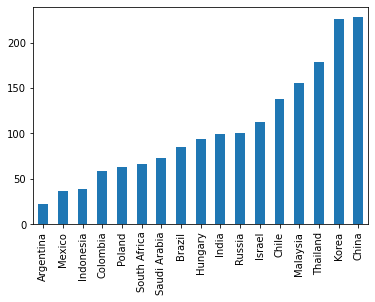

In [6]:
df3 = pd.read_csv('https://www.bis.org/statistics/full_credit_gap_csv.zip',on_bad_lines='skip')
df3.set_index(["Borrowers' country"],inplace=True)
df_gap = df3[df3["Credit gap data type"] == 'Credit-to-GDP gaps (actual-trend)']
df_gap
em_list = ["Argentina","Brazil","Chile","China","Colombia","Hungary","Indonesia","Israel",
                "India","Korea","Mexico","Malaysia","Poland","Russia","Saudi Arabia","Thailand",
                "South Africa"] #,"Czech Republic"
df_gap = df_gap.T
df_gap.columns = [x for x in df_gap.columns.tolist()]
df_ratio = df3[df3["Credit gap data type"] == 'Credit-to-GDP ratios (actual data)'].T
df_ratio.columns = [x for x in df_ratio.columns.tolist()]
df_ratio
#df_gap

df_ratio[em_list].iloc[-1].sort_values().plot(kind="bar")

In [7]:
df_credit = pd.merge(df_gap[em_list].iloc[-1],df_ratio[em_list].iloc[-1],left_index=True,right_index=True)
df_credit.columns = ["Credit Gap","Credit to GDP"]
df_credit = df_credit.sort_values(by = ["Credit Gap","Credit to GDP"],ascending=False)
df_credit.to_csv("credit_gaps.csv")
df_credit

fig = px.scatter(df_credit, x="Credit Gap",y="Credit to GDP",text=df_credit.index)
fig.show()


<AxesSubplot:>

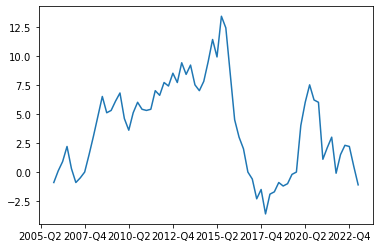

In [8]:
df_gap[em_list][13:].apply(pd.to_numeric)["Brazil"].plot()



In [9]:
#linear regression on ratings
# df_for_reg = new_df[new_df["Rating"] < 17]

# X = df_for_reg["Rating"].values.reshape(-1,1)
# y = df_for_reg["YTW"].values.reshape(-1,1)
# print(f"X is type {type(X)} and shape {X.shape}")
# print(f"y is type {type(y)} and shape {y.shape}")

# # all parameters not specified are set to their defaults
# linearR = LinearRegression()
# linearR.fit(X,y)

# # #use the trainged model to make predictions
# predictions = linearR.predict(X)

# # #I create a datframe to quickly look at whether the predictions worked
# dfp = pd.DataFrame(zip(predictions,df_for_reg["YTW"],df_for_reg["Rating"],df_for_reg.index))
# dfp.columns = ["predictions","YTW","rating","country"]
# dfp["diff"] = dfp["YTW"] - dfp["predictions"]
# dfp["predictions"] = [x[0] for x in dfp["predictions"]]
# dfp["diff"] = [x[0] for x in dfp["diff"]]
# dfp = dfp.set_index("country")
# dfp.sort_values("diff")["diff"].plot(kind="bar")